In [1]:
#meta 6/3/2021 myCassava Image Classifier w/ TFHub Pre-Trained Model 
#Using pre-trained Cassava disease classification model (not Cassava disease feature vector model)
#input: Kaggle competition images 
#output: A probability vector of of 6 cassava classes

#history
#6/3/2021 IMAGE CLASSIFIER w/PRETRAINED MODEL
#     Predict on a small subset of train images
#     Note: error with more images -> todo: figure out batches
#     Accuracy ~88.04%

#ref CropNet: Cassava Disease Detection
#src https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/cropnet_cassava.ipynb#scrollTo=b6eIWkTjIQhS

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# List files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:5]:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cassava-leaf-disease-classification/sample_submission.csv
/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json
/kaggle/input/cassava-leaf-disease-classification/train.csv
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train14-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train13-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train04-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train01-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/ld_train08-1338.tfrec
/kaggle/input/cassava-leaf-disease-classification/test_tfrecords/ld_test00-1.tfrec
/kaggle/input/cassava-leaf-disease-classification/train_images/1235188286.jpg
/kaggle/input/cassava-leaf-disease-classification/train_images/1215607589.jpg
/kaggle/input/cassava-leaf-disease-classification/train_images/478554372.jpg
/kaggle/input/cassava-leaf-disea

# TFHub  - Cassave Disease Image Classifier 
Using pre-trained Cassava disease classification model from Tensorflow Hub.  
This model is trained to classify an input image into one of 6 cassava disease classes: Bacterial Blight, Brown Streak Disease, Green Mite, Mosaic Disease, Healthy, and Unknown.  
Refer to https://tfhub.dev/google/cropnet/classifier/cassava_disease_V1/2

Note: not the same as Cassava disease feature vector model  
Refer to https://tfhub.dev/google/cropnet/feature_vector/cassava_disease_V1/1

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import json
from sklearn.model_selection import train_test_split

import tensorflow as tf # TF2 version
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
#print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.4.1
Hub version: 0.12.0


In [4]:
#--constants and variables
SEED = 24
PATH_FULL = '../input/cassava-leaf-disease-classification/'
PATH_TRAIN = '../input/cassava-leaf-disease-classification/train_images/'

#BATCH_SIZE = 32
IMAGE_SHAPE = (224, 224) # input dimensions required by the CNN model
NUM_CLASSES = 6

In [5]:
# transform from an RGB image to tensor
def preprocess_image(image_path):
    image_string = tf.io.read_file(image_path)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    # Normalize [0, 255] to [0, 1]
    image = tf.cast(image_decoded, tf.float32)
    image = image / 255.
    # Resize the images to 224 x 224
    image = tf.image.resize(image, IMAGE_SHAPE)
    
    return image

# transform from an RGB image to tensor, with image display
# src https://github.com/LaurentVeyssier/Bird_Classifier_Tensorflow_Colab_Notebook/blob/master/BirdClassifier.ipynb
from keras.preprocessing import image 
def preprocess_image2(img_path, ax):
    img = image.load_img(img_path, target_size = IMAGE_SHAPE)       # loads RGB image as PIL.Image.Image type, resize image to model input dimensions
    ax.imshow(img, alpha=1)
    x = image.img_to_array(img)/255.0                               # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3) and normalize to [0:1] as per model requierements
    x = np.expand_dims(x, axis=0)                                   # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return x                                                        # return 4D tensor

## 0. Get Data
Cassava leaf images provided by the competition

In [6]:
# list all files under the train directory
for train_dirname, _, train_filenames in os.walk(PATH_TRAIN):
    for train_filename in train_filenames[:5]:
        print(os.path.join(train_dirname, train_filename))
        
#full path to train images
train_filepaths = []
[train_filepaths.append(PATH_TRAIN + x) for x in train_filenames[1:]]
train_filepaths[:5]

../input/cassava-leaf-disease-classification/train_images/1235188286.jpg
../input/cassava-leaf-disease-classification/train_images/1215607589.jpg
../input/cassava-leaf-disease-classification/train_images/478554372.jpg
../input/cassava-leaf-disease-classification/train_images/2763304605.jpg
../input/cassava-leaf-disease-classification/train_images/2826122413.jpg


['../input/cassava-leaf-disease-classification/train_images/1215607589.jpg',
 '../input/cassava-leaf-disease-classification/train_images/478554372.jpg',
 '../input/cassava-leaf-disease-classification/train_images/2763304605.jpg',
 '../input/cassava-leaf-disease-classification/train_images/2826122413.jpg',
 '../input/cassava-leaf-disease-classification/train_images/111117998.jpg']

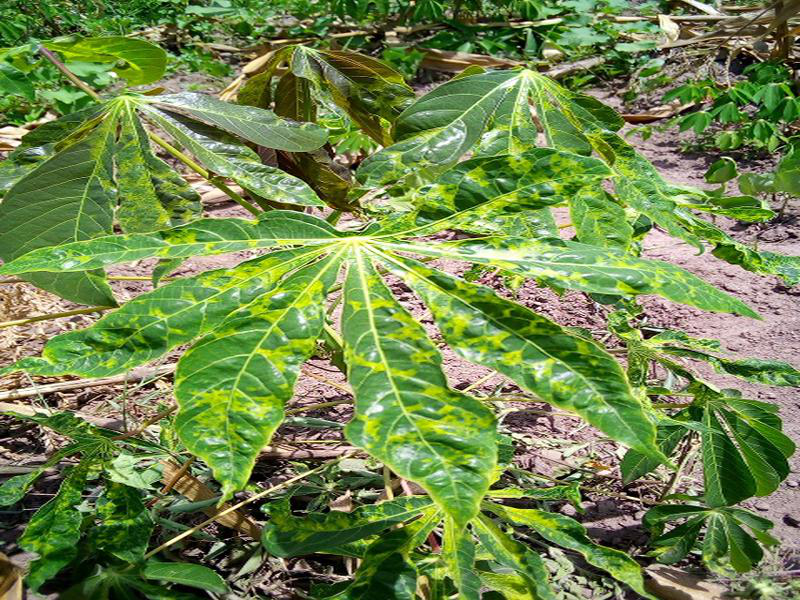

In [7]:
#view an image example
im1 = Image.open(train_filepaths[0])
im1

In [8]:
#labels
with open((PATH_FULL + '/label_num_to_disease_map.json')) as json_file:
    target_map = json.load(json_file)
    
# Extend the cassava dataset classes with 'unknown'
target_map['5']='Unknown'
print(target_map)

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy', '5': 'Unknown'}


In [9]:
#train ds with image_id and labels
df_train = pd.read_csv(PATH_FULL + '/train.csv')
print('train data\n', df_train.shape)
df_train.info()

train data
 (21397, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


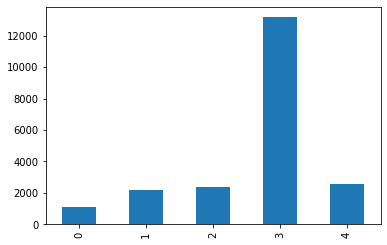

In [10]:
#display(df_train.head())
df_train['label'].value_counts().sort_index().plot(kind='bar');

In [11]:
df_train['full_path'] = PATH_TRAIN + df_train['image_id']
df_train.head()

,image_id,label,full_path
0,1000015157.jpg,0,../input/cassava-leaf-disease-classification/t...
1,1000201771.jpg,3,../input/cassava-leaf-disease-classification/t...
2,100042118.jpg,1,../input/cassava-leaf-disease-classification/t...
3,1000723321.jpg,1,../input/cassava-leaf-disease-classification/t...
4,1000812911.jpg,3,../input/cassava-leaf-disease-classification/t...


In [12]:
#define a small ds to predict on
df_train, df_valid = train_test_split(df_train, test_size=0.05, random_state=SEED)
print(df_train.shape, df_valid.shape)
df_valid.head()

(20327, 3) (1070, 3)


,image_id,label,full_path
12322,3208046657.jpg,3,../input/cassava-leaf-disease-classification/t...
4128,1737140400.jpg,3,../input/cassava-leaf-disease-classification/t...
5128,1915645722.jpg,4,../input/cassava-leaf-disease-classification/t...
19409,624542244.jpg,2,../input/cassava-leaf-disease-classification/t...
15307,3750670092.jpg,3,../input/cassava-leaf-disease-classification/t...


## 1. Prep Data - Transform Image(s)
try ref https://financial-engineering.medium.com/tensorflow-2-0-load-images-to-tensorflow-897b8b067fc2

In [13]:
#my transform example 
im1_tensor = preprocess_image(train_filepaths[0])
im1_tensor.shape

TensorShape([224, 224, 3])

(1, 224, 224, 3)

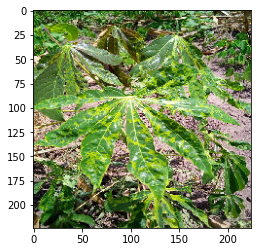

In [14]:
#transform example with image display
im1_tensor_show = preprocess_image2(train_filepaths[0], plt)
im1_tensor_show

im1_tensor_show.shape

In [15]:
#transform images
images = []
[images.append(preprocess_image(x)) for x in df_valid['full_path']]

len(images), images[0]

(1070,
 <tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.73607445, 0.7577231 , 0.7096839 ],
         [0.7734294 , 0.80361146, 0.7269408 ],
         [0.7237895 , 0.7640556 , 0.62477994],
         ...,
         [0.17134883, 0.23409393, 0.12955204],
         [0.09631814, 0.13669467, 0.08167222],
         [0.13190287, 0.1390257 , 0.12511021]],
 
        [[0.8337835 , 0.84811926, 0.7369148 ],
         [0.77011806, 0.8057623 , 0.6071129 ],
         [0.642437  , 0.694948  , 0.3964586 ],
         ...,
         [0.17177892, 0.25305146, 0.21777725],
         [0.11236585, 0.1758916 , 0.16670786],
         [0.10319157, 0.13424389, 0.14732921]],
 
        [[0.77409965, 0.79713887, 0.5141557 ],
         [0.66958785, 0.72257906, 0.33656463],
         [0.57015806, 0.64609843, 0.18727489],
         ...,
         [0.15871322, 0.24935937, 0.2930069 ],
         [0.20962493, 0.28649586, 0.32576156],
         [0.22098845, 0.27655068, 0.3120649 ]],
 
        ...,
 
        [[0.36516505, 0.2

## 2. Model

### 2.0 Load Pretrained Model to Classify Images
- Input  
This model takes images as input.  Inputs are expected to be 3-channel RGB color images of size 224 x 224, scaled to [0, 1].

- Output  
This model outputs to image_classifier: A float tensor of shape [batch size, 6] representing probabilities, with classes corresponding to labelmap.  

Note: not this model outputs to image_feature_vector: A float tensor of shape [batch size, 1280].


In [16]:
#load the Cassava disease classification model from TFHub
URL = 'https://tfhub.dev/google/cropnet/classifier/cassava_disease_V1/2'
classify = hub.KerasLayer(URL)

In [17]:
#save model
model_name = 'cassava_disease_V1'
saved_model_path = f"model_{model_name}"
tf.saved_model.save(classify, saved_model_path)

## 4. Predict

In [18]:
#predict 
probabilities = classify(images) #$error with more images.  $todo: figure out batch
predictions = tf.argmax(probabilities, axis=-1)
predictions

<tf.Tensor: shape=(1070,), dtype=int64, numpy=array([3, 3, 4, ..., 3, 3, 2])>

In [19]:
# Calculate the accuracy of the model
metric = tf.keras.metrics.Accuracy()

predictions = tf.math.argmax(probabilities, axis=-1)
labels = df_valid['label']
metric.update_state(labels, predictions)

print('Accuracy: %.4f' % (metric.result().numpy()))

Accuracy: 0.8804


## Xtra

##### My manual accuracy calculation

In [20]:
df_valid['label_predicted'] = pd.Series(predictions).values
print(df_valid.shape)
display(df_valid.head())

(df_valid['label'] == df_valid['label_predicted']).sum() / df_valid.shape[0]

(1070, 4)


,image_id,label,full_path,label_predicted
12322,3208046657.jpg,3,../input/cassava-leaf-disease-classification/t...,3
4128,1737140400.jpg,3,../input/cassava-leaf-disease-classification/t...,3
5128,1915645722.jpg,4,../input/cassava-leaf-disease-classification/t...,4
19409,624542244.jpg,2,../input/cassava-leaf-disease-classification/t...,2
15307,3750670092.jpg,3,../input/cassava-leaf-disease-classification/t...,3


0.8803738317757009

In [21]:
mystop

NameError: name 'mystop' is not defined

In [ ]:
#Let's load this data into our model using images off disk using image_dataset_from_directory.
data_root = '/kaggle/input/cassava-leaf-disease-classification/train_images/'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMAGE_SHAPE,
  batch_size=BATCH_SIZE)